## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.multitest as multitest
import datetime as dt
from tqdm.notebook import tqdm
from plotly import graph_objects as go
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/ЯП/Проекты/df/logs_exp.csv', sep='\t')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
pd.options.display.max_colwidth = 100
display(df.head())
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Предобработка

In [4]:
df.rename({'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time', 'ExpId':'experiment_id'}, axis=1, inplace = True)

In [5]:
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

In [6]:
# проверяем пропуски
numbers_of_nulls = pd.DataFrame(columns=['names'], data=df.columns)
numbers_of_nulls['nulls'] = df.isnull().sum().values
numbers_of_nulls['nulls_percent'] = 100*numbers_of_nulls['nulls']/df.shape[0]
numbers_of_nulls

,names,nulls,nulls_percent
0,event_name,0,0.0
1,user_id,0,0.0
2,event_time,0,0.0
3,experiment_id,0,0.0


*Пропусков нет.*

In [7]:
# проверяем явные дубликаты
df.duplicated().sum()

413

*413 повторяющихся строк в дф, скорее всего это техническая ошибка, поскольку каждое событие зафиксировано с точностью до секунд.*

In [8]:
# удаляем дубликаты
df.drop_duplicates(inplace=True)

In [9]:
# добавляем столбец с датой
df['event_date'] = df['event_time'].dt.date

In [10]:
# проверяем нет ли пользователей, попавших в разные группы
t = df.groupby('user_id', as_index=False)['experiment_id'].nunique()
t = t[t['experiment_id'] > 1]['user_id'].count()
print(f'Всего пользователей попавших разные группы: {t}')

Всего пользователей попавших разные группы: 0


## Исследовательский анализ

In [11]:
# сколько всего событий в логе
df['event_name'].nunique()

5

In [12]:
# сколько всего пользователей в логе
df['user_id'].nunique()

7551

In [13]:
# cколько в среднем событий приходится на пользователя
round(df.groupby('user_id')['event_name'].count().mean())

32

In [14]:
# проверим минимальную и максимальную дату в выгрузке
df['event_date'].agg(['min', 'max'])

min    2019-07-25
max    2019-08-07
Name: event_date, dtype: object

In [15]:
# количество дней наблюдений
((df['event_date'].agg('max') + dt.timedelta(days=1)) - df['event_date'].agg('min')).days

14

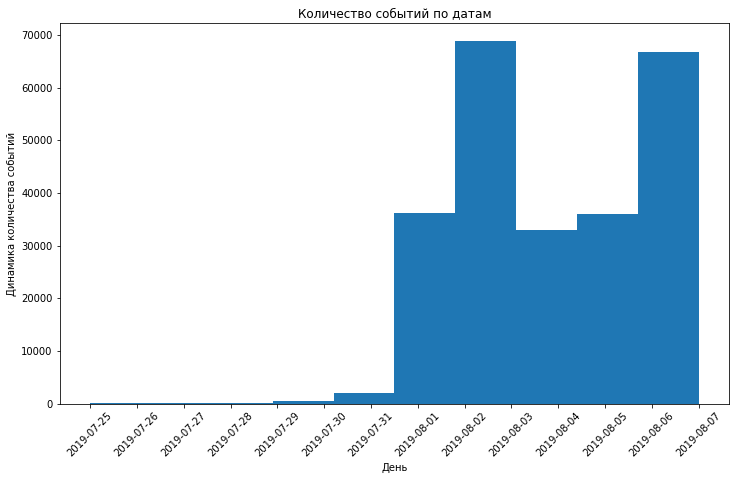

In [16]:
# построим гистограмму и проверим за какие дни у нас достаточно наблюдений
plt.figure(figsize=(12, 7))
plt.hist(df['event_date'])
plt.xticks(np.arange(min(df['event_date']), max(df['event_date']) + dt.timedelta(days=1)), rotation=45)
plt.title('Количество событий по датам')
plt.ylabel('Динамика количества событий')
plt.xlabel('День')
plt.show()

In [17]:
# посмотрим сколько данных от общего числа составляет часть, полученная до 01-08-2019
round((len(df[df['event_date'] < dt.date(2019,8,1)]) * 100 / len(df)),2)

1.16

In [18]:
# посмотрим сколько пользователей были активны только до 01-08-2019
t = pd.Series(df.groupby(['user_id'])['event_date'].agg('last') < dt.date(2019,8,1)).reset_index()
t['event_date'] = t['event_date'] * 1
print('Количество неактивных пользователей после 31-07-2019:', len(t[t['event_date'] > 0]))
print('Количество неактивных пользователей после 31-07-2019 от общего числа:', \
      round(len(t[t['event_date'] > 0]) * 100 / df['user_id'].nunique(), 2))

Количество неактивных пользователей после 31-07-2019: 17
Количество неактивных пользователей после 31-07-2019 от общего числа: 0.23


*17 пользователей были не активны после 31-07-2019.*

In [19]:
# посмотрим какие и сколько было событий у этих пользователей
t = pd.Series(df.groupby(['user_id'])['event_date'].agg('last') < dt.date(2019,8,1)).reset_index()
t['event_date'] = t['event_date'] * 1
inactive_user_list = t[t['event_date'] > 0]['user_id'].to_list()
t = df[df['user_id'].isin(inactive_user_list)]
t['event_name'].value_counts()

MainScreenAppear      58
OffersScreenAppear     6
CartScreenAppear       5
Name: event_name, dtype: int64

*58 MainScreenAppear, 6 OffersScreenAppear и 5 CartScreenAppear - количество событий, совершенных этими пользователями.*

*Принимаем решение отбросить записи до 01-08-2019, будем считать, что достаточное количество данных у нас начинается с этого дня.*

In [20]:
# отбрасываем данные до 01-08-2019
df = df[df['event_date'] >= dt.date(2019,8,1)]

In [21]:
# проверяем сколько групп в тесте и пользователей в каждой группе
t = df.groupby('experiment_id')['user_id'].nunique()
display(t)
print('Разница в количестве между группами %:',round((((t.to_list()[2] - t.to_list()[0]) / t.to_list()[0]) * 100),2))

experiment_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Разница в количестве между группами %: 2.13


*Больше всего пользователей в группе 248, разница с наименьшей 246 группой около 2%. Примем это за погрешность.*

## Изучение воронки событий

### Посмотрим какие события есть в логе и их частоту.

In [22]:
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

*Большая часть записей относится к событию "просмотрена главная страница", туториалы открываются редко.*

### Посчитаем сколько пользователей совершило каждое событие, посчитаеи долю тех, кто хоть раз совершили событие.

In [23]:
# считаем сколько пользователей совершили все события
t = (df.groupby('user_id')['event_name'].agg('nunique') > 4).reset_index()
t['event_name'] = t['event_name'] * 1
print('Всего пользователей, совершивших все события хотя бы раз:', t[t['event_name'] > 0]['user_id'].count())
print('Доля пользователей, совершивших все события хотя бы раз:', (t[t['event_name'] > 0]['user_id'].count()) * 100 / df['user_id'].nunique())

Всего пользователей, совершивших все события хотя бы раз: 466
Доля пользователей, совершивших все события хотя бы раз: 6.185293336872843


*466 пользователей совершили все события*

In [24]:
# считаем сколько пользователей совершили каждое событие
df.groupby('event_name')['user_id'].agg('nunique').reset_index().sort_values(
    by='user_id', ascending=False)

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


*Чаще всего пользователи совершают событие "просмотрена главная страница"*

In [25]:
# считаем долю пользователей, которые хоть раз совершали событие
def event_share(event_name):
    return print(f'Доля пользователей, совершивших {event_name}:', 
                 round(df[df['event_name'] == event_name]['user_id'].nunique() * 100 / df['user_id'].nunique(), 1))

In [26]:
event_share('MainScreenAppear')
event_share('OffersScreenAppear')
event_share('CartScreenAppear')
event_share('PaymentScreenSuccessful')
event_share('Tutorial')

Доля пользователей, совершивших MainScreenAppear: 98.5
Доля пользователей, совершивших OffersScreenAppear: 61.0
Доля пользователей, совершивших CartScreenAppear: 49.6
Доля пользователей, совершивших PaymentScreenSuccessful: 47.0
Доля пользователей, совершивших Tutorial: 11.1


### Сделаем предположение о последовательности событий (определим предполагаемую воронку).

Предположим, что события должны следовать в следующем порядке:

1) просмотр главной страницы - MainScreenAppear

2) просмотр туториала - Tutorial (**опционально**)

3) просмотр страницы со стоимостью - OffersScreenAppear

4) просмотр страницы корзины - CartScreenAppear

5) просмотр страницы подтверждения оплаты - PaymentScreenSuccessful

### По воронке посчитаем долю пользователей, которая проходит на следующий этап воронки (от числа пользователей на предыдущем).

In [27]:
def get_retention (event_name_a, event_name_b):
    return print(f'Доля пользователей, перешедших из {event_name_a} в {event_name_b}:'
    ,round(100 - (((df[df['event_name'] == event_name_a]['user_id'].nunique() 
    - df[df['event_name'] == event_name_b]['user_id'].nunique())
    / df[df['event_name'] == event_name_a]['user_id'].nunique())*100),1))

In [28]:
get_retention ('MainScreenAppear', 'Tutorial')
get_retention ('MainScreenAppear', 'OffersScreenAppear')
get_retention ('OffersScreenAppear', 'CartScreenAppear')
get_retention ('CartScreenAppear', 'PaymentScreenSuccessful')

Доля пользователей, перешедших из MainScreenAppear в Tutorial: 11.3
Доля пользователей, перешедших из MainScreenAppear в OffersScreenAppear: 61.9
Доля пользователей, перешедших из OffersScreenAppear в CartScreenAppear: 81.3
Доля пользователей, перешедших из CartScreenAppear в PaymentScreenSuccessful: 94.8


In [29]:
# посмотрим также в разрезе экспериментальной группы
def get_retention_by_exp (event_name_a, event_name_b, experiment_id):
    return print(f'Доля пользователей, перешедших из {event_name_a} в {event_name_b} в группе {experiment_id}:'
    ,round(100 - (((df[((df['event_name'] == event_name_a) & (df['experiment_id'] == experiment_id))]['user_id'].nunique() 
    - df[((df['event_name'] == event_name_b) & (df['experiment_id'] == experiment_id))]['user_id'].nunique())
    / df[((df['event_name'] == event_name_a) & (df['experiment_id'] == experiment_id))]['user_id'].nunique())*100),1))

In [30]:
get_retention_by_exp ('MainScreenAppear', 'Tutorial', 246)
get_retention_by_exp ('MainScreenAppear', 'OffersScreenAppear', 246)
get_retention_by_exp ('OffersScreenAppear', 'CartScreenAppear', 246)
get_retention_by_exp ('CartScreenAppear', 'PaymentScreenSuccessful', 246)
print()
get_retention_by_exp ('MainScreenAppear', 'Tutorial', 247)
get_retention_by_exp ('MainScreenAppear', 'OffersScreenAppear', 247)
get_retention_by_exp ('OffersScreenAppear', 'CartScreenAppear', 247)
get_retention_by_exp ('CartScreenAppear', 'PaymentScreenSuccessful', 247)
print()
get_retention_by_exp ('MainScreenAppear', 'Tutorial', 248)
get_retention_by_exp ('MainScreenAppear', 'OffersScreenAppear', 248)
get_retention_by_exp ('OffersScreenAppear', 'CartScreenAppear', 248)
get_retention_by_exp ('CartScreenAppear', 'PaymentScreenSuccessful', 248)
print()

Доля пользователей, перешедших из MainScreenAppear в Tutorial в группе 246: 11.3
Доля пользователей, перешедших из MainScreenAppear в OffersScreenAppear в группе 246: 62.9
Доля пользователей, перешедших из OffersScreenAppear в CartScreenAppear в группе 246: 82.1
Доля пользователей, перешедших из CartScreenAppear в PaymentScreenSuccessful в группе 246: 94.8

Доля пользователей, перешедших из MainScreenAppear в Tutorial в группе 247: 11.4
Доля пользователей, перешедших из MainScreenAppear в OffersScreenAppear в группе 247: 61.4
Доля пользователей, перешедших из OffersScreenAppear в CartScreenAppear в группе 247: 81.4
Доля пользователей, перешедших из CartScreenAppear в PaymentScreenSuccessful в группе 247: 93.5

Доля пользователей, перешедших из MainScreenAppear в Tutorial в группе 248: 11.2
Доля пользователей, перешедших из MainScreenAppear в OffersScreenAppear в группе 248: 61.4
Доля пользователей, перешедших из OffersScreenAppear в CartScreenAppear в группе 248: 80.3
Доля пользователе

### Выясним на каком из этапов теряется больше всего пользователей

Если не считать туториал, то больше всего пользователей теряются при переходе с главной страницы на страницу товара со стоимостью - около 40%.

Показатели в разрезе групп почти не отличаются, у группы 248 лучший показатель перехода из корзины на страницу подтвреждения оплаты.

У группы 246 лучший показатель перехода с главной страницы на страницу товара со стоимостью.

У группы 248 худший показатель перехода со страницы товара со стоимостью на страницу карзины.

### Узнаем какая доля пользователей доходит от первого этапа до последнего

In [31]:
get_retention ('MainScreenAppear', 'PaymentScreenSuccessful')

Доля пользователей, перешедших из MainScreenAppear в PaymentScreenSuccessful: 47.7


In [32]:
# посмотрим также в разрезе групп
get_retention_by_exp ('MainScreenAppear', 'PaymentScreenSuccessful', 246)
print()
get_retention_by_exp ('MainScreenAppear', 'PaymentScreenSuccessful', 247)
print()
get_retention_by_exp ('MainScreenAppear', 'PaymentScreenSuccessful', 248)
print()

Доля пользователей, перешедших из MainScreenAppear в PaymentScreenSuccessful в группе 246: 49.0

Доля пользователей, перешедших из MainScreenAppear в PaymentScreenSuccessful в группе 247: 46.8

Доля пользователей, перешедших из MainScreenAppear в PaymentScreenSuccessful в группе 248: 47.4



*Менее 50% доходят от главной страницы до подтверждения оплаты. По группам лучший показатель у группы 246 - 49%.*

In [33]:
# визуализируем воронку
fig = go.Figure(go.Funnel(
    y = ['Главная страница', 'Страница товара', 'Корзина', 'Страница подтверждения оплаты'],
    x = [df[df['event_name'] == 'MainScreenAppear']['user_id'].nunique(),
         df[df['event_name'] == 'OffersScreenAppear']['user_id'].nunique(),
         df[df['event_name'] == 'CartScreenAppear']['user_id'].nunique(),
         df[df['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()
        ]))

fig.update_layout(title='Воронка переходов')
fig.show()

## Изучение результатов эксперимента

### Перед началом изучения еще раз выведем сколько у нас пользователей в каждой группе

In [34]:
users_by_experiment = df.groupby('experiment_id')['user_id'].nunique().reset_index()
display(users_by_experiment)

,experiment_id,user_id
0,246,2484
1,247,2513
2,248,2537


In [35]:
# сделаем сводную таблицу с количеством уникальных пользователей по каждому событию и долей пользователей, отметившихся в данном событии отобщего числа пользователей в группе
users_by_events = pd.pivot_table(df, index='experiment_id', columns='event_name', values='user_id', aggfunc='nunique')
users_by_events = users_by_experiment.merge(users_by_events, on='experiment_id')
users_by_events.rename({'user_id':'users_count'}, axis=1, inplace=True)

users_by_events.loc['total'] = users_by_events.sum()
users_by_events.loc['total_246_247'] = users_by_events.loc[0:1,:].sum()

users_by_events = users_by_events.reset_index()
users_by_events.drop('index', axis=1, inplace = True)
users_by_events['experiment_id'].replace({741: 'total', 493: 'control_total'}, inplace = True)

users_by_events['MainScreenAppear_share'] = users_by_events['MainScreenAppear'] * 100 / users_by_events['users_count']
users_by_events['Tutorial_share'] = users_by_events['Tutorial'] * 100 / users_by_events['users_count']
users_by_events['OffersScreenAppear_share'] = users_by_events['OffersScreenAppear'] * 100 / users_by_events['users_count']
users_by_events['CartScreenAppear_share'] = users_by_events['CartScreenAppear'] * 100 / users_by_events['users_count']
users_by_events['PaymentScreenSuccessful_share'] = users_by_events['PaymentScreenSuccessful'] * 100 / users_by_events['users_count']

users_by_events

,experiment_id,users_count,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,MainScreenAppear_share,Tutorial_share,OffersScreenAppear_share,CartScreenAppear_share,PaymentScreenSuccessful_share
0,246,2484,1266,2450,1542,1200,278,98.631240,11.191626,62.077295,50.966184,48.309179
1,247,2513,1238,2476,1520,1158,283,98.527656,11.261441,60.485476,49.263828,46.080382
2,248,2537,1230,2493,1531,1181,279,98.265668,10.997241,60.346866,48.482460,46.551045
3,total,7534,3734,7419,4593,3539,840,98.473586,11.149456,60.963632,49.561986,46.973719
4,control_total,4997,2504,4926,3062,2358,561,98.579147,11.226736,61.276766,50.110066,47.188313


In [36]:
# визуализируем воронку по группам
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 246,
    y = ['Главная страница', 'Страница товара', 'Корзина', 'Страница подтверждения оплаты'],
    x = [users_by_events.loc[0, 'MainScreenAppear'],
         users_by_events.loc[0, 'OffersScreenAppear'],
         users_by_events.loc[0, 'CartScreenAppear'],
         users_by_events.loc[0, 'PaymentScreenSuccessful']],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 247,
    y = ['Главная страница', 'Страница товара', 'Корзина', 'Страница подтверждения оплаты'],
    x = [users_by_events.loc[1, 'MainScreenAppear'],
         users_by_events.loc[1, 'OffersScreenAppear'],
         users_by_events.loc[1, 'CartScreenAppear'],
         users_by_events.loc[1, 'PaymentScreenSuccessful']],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 248,
    y = ['Главная страница', 'Страница товара', 'Корзина', 'Страница подтверждения оплаты'],
    x = [users_by_events.loc[2, 'MainScreenAppear'],
         users_by_events.loc[2, 'OffersScreenAppear'],
         users_by_events.loc[2, 'CartScreenAppear'],
         users_by_events.loc[2, 'PaymentScreenSuccessful']],
    textinfo = "value+percent previous"))

fig.update_layout(title='Воронка переходов')
fig.show()

### Проверим корректность работы механизма разделения пользователей по группам. Проверим есть ли статистически значимые различия в конверсии на каждом этапе воронки в группах 246 и 247.

*Для проверки гипотезы будем использовать z тест и бутстрап.*    
*Н0 - стат. значимых различий нет.*   
*H1 - стат. значимые различия есть.*   
*Установим уровень значимости - 5%*

In [37]:
def get_retention_by_event(event, group_a, group_b):
    alpha = 0.05

    if group_a == 246:
        sample_successes_a = event.to_list()[0]
    elif group_a == 247:
        sample_successes_a = event.to_list()[1]
    elif group_a == 248:
        sample_successes_a = event.to_list()[2]
    elif group_a == 'control_total':
        sample_successes_a = event.to_list()[4]

    if group_b == 246:
        sample_successes_b = event.to_list()[0]
    elif group_b == 247:
        sample_successes_b = event.to_list()[1]
    elif group_b == 248:
        sample_successes_b = event.to_list()[2]    
    elif group_b == 'control_total':
        sample_successes_b = event.to_list()[4] 

    if group_a == 246:
        sample_a_tries = users_by_events['users_count'].to_list()[0]
    elif group_a == 247:
        sample_a_tries = users_by_events['users_count'].to_list()[1]
    elif group_a == 248:
        sample_a_tries = users_by_events['users_count'].to_list()[2]
    elif group_a == 'control_total':
        sample_a_tries = users_by_events['users_count'].to_list()[4]

    if group_b == 246:
        sample_b_tries = users_by_events['users_count'].to_list()[0]
    elif group_b == 247:
        sample_b_tries = users_by_events['users_count'].to_list()[1]
    elif group_b == 248:
        sample_b_tries = users_by_events['users_count'].to_list()[2]   
    elif group_b == 'control_total':
        sample_b_tries = users_by_events['users_count'].to_list()[4]

    result = proportions_ztest([sample_successes_a,sample_successes_b],[sample_a_tries,sample_b_tries], alternative='two-sided')[1]
    
    if result > alpha:
        return print(f'Не можем отклонить Н0.\nP-value: {result}')
    else:
        return print(f'Отклоняем Н0.\nP-value:, {result}')

In [38]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event(users_by_events['MainScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event(users_by_events['Tutorial'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event(users_by_events['OffersScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event(users_by_events['CartScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event(users_by_events['PaymentScreenSuccessful'], 246, 247)

Сравнение пропорций между группами - посещение главной страницы:
Не можем отклонить Н0.
P-value: 0.7570597232046099

Сравнение пропорций между группами - посещение туториала:
Не можем отклонить Н0.
P-value: 0.9376996189257114

Сравнение пропорций между группами - посещение страницы товара:
Не можем отклонить Н0.
P-value: 0.2480954578522181

Сравнение пропорций между группами - посещение корзины:
Не можем отклонить Н0.
P-value: 0.22883372237997213

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:
Не можем отклонить Н0.
P-value: 0.11456679313141847


*Стат. значимых различий нет.*

In [39]:
# проверим с помощью бутстрапа
def get_retention_by_event_bs(event, group_a, group_b):
    alpha = 0.01

    if group_a == 246:
        sample_successes_a = pd.Series(event.to_list()[0]*[1])
    elif group_a == 247:
        sample_successes_a = pd.Series(event.to_list()[1]*[1])
    elif group_a == 248:
        sample_successes_a = pd.Series(event.to_list()[2]*[1])
    elif group_a == 'control_total':
        sample_successes_a = pd.Series(event.to_list()[4]*[1])

    if group_b == 246:
        sample_successes_b = pd.Series(event.to_list()[0]*[1])
    elif group_b == 247:
        sample_successes_b = pd.Series(event.to_list()[1]*[1])
    elif group_b == 248:
        sample_successes_b = pd.Series(event.to_list()[2]*[1]) 
    elif group_b == 'control_total':
        sample_successes_b = pd.Series(event.to_list()[4]*[1])

    if group_a == 246:
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[0] - event.to_list()[0])*[0])
    elif group_a == 247:
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[1] - event.to_list()[1])*[0])
    elif group_a == 248:
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[2] - event.to_list()[2])*[0])
    elif group_a == 'control_total':
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[4] - event.to_list()[4])*[0])

    if group_b == 246:
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[0] - event.to_list()[0])*[0])
    elif group_b == 247:
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[1] - event.to_list()[1])*[0])
    elif group_b == 248:
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[2] - event.to_list()[2])*[0])
    elif group_b == 'control_total':
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[4] - event.to_list()[4])*[0])

    sample_a = sample_successes_a.append(sample_tries_a, ignore_index=True)
    sample_b = sample_successes_b.append(sample_tries_b, ignore_index=True)

    result = []
    sample_size = 2000
    for _ in tqdm(range(10000)):
        a = np.random.choice(sample_a,size=sample_size)
        b = np.random.choice(sample_b,size=sample_size)
        _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)], alternative='two-sided')
        result.append(pval)
    if pd.Series(result).mean() > alpha:
        return print(f'Не можем отклонить Н0.\nP-value: {pd.Series(result).mean()}')
    else:
        return print(f'Отклоняем Н0.\nP-value:, {pd.Series(result).mean()}')

In [40]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs(users_by_events['MainScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs(users_by_events['Tutorial'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs(users_by_events['OffersScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs(users_by_events['CartScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs(users_by_events['PaymentScreenSuccessful'], 246, 247)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.49122308812535376

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.502299074939789

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.3541885007713908

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.3454990983132906

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.27239260309851243


*Стат. значимых различий нет.*

Поскольку стат. значимых различий не выявлено, можно сказать, что данные выборки пришли из одного распределения и механизм разделения пользователей работает корректно.

### Сравним аналогично по отдельности контрольные группы с экспериментальной, сделаем выводы

In [41]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event(users_by_events['MainScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event(users_by_events['Tutorial'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event(users_by_events['OffersScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event(users_by_events['CartScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event(users_by_events['PaymentScreenSuccessful'], 246, 248)

Сравнение пропорций между группами - посещение главной страницы:
Не можем отклонить Н0.
P-value: 0.2949721933554553

Сравнение пропорций между группами - посещение туториала:
Не можем отклонить Н0.
P-value: 0.8264294010087645

Сравнение пропорций между группами - посещение страницы товара:
Не можем отклонить Н0.
P-value: 0.20836205402738917

Сравнение пропорций между группами - посещение корзины:
Не можем отклонить Н0.
P-value: 0.07842923237520125

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:
Не можем отклонить Н0.
P-value: 0.21225532756977972


In [42]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs(users_by_events['MainScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs(users_by_events['Tutorial'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs(users_by_events['OffersScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs(users_by_events['CartScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs(users_by_events['PaymentScreenSuccessful'], 246, 248)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.374709959345474

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.4925336030436086

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.33120050689870806

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.229814035228903

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.33806732220505836


*Стат. значимых различий между группами 246 и 248 нет.*

In [43]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event(users_by_events['MainScreenAppear'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event(users_by_events['Tutorial'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event(users_by_events['OffersScreenAppear'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event(users_by_events['CartScreenAppear'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event(users_by_events['PaymentScreenSuccessful'], 247, 248)

Сравнение пропорций между группами - посещение главной страницы:
Не можем отклонить Н0.
P-value: 0.45870536166215137

Сравнение пропорций между группами - посещение туториала:
Не можем отклонить Н0.
P-value: 0.7653239224745011

Сравнение пропорций между группами - посещение страницы товара:
Не можем отклонить Н0.
P-value: 0.919781783059226

Сравнение пропорций между группами - посещение корзины:
Не можем отклонить Н0.
P-value: 0.5786197879539782

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:
Не можем отклонить Н0.
P-value: 0.7373415053803964


In [44]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs(users_by_events['MainScreenAppear'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs(users_by_events['Tutorial'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs(users_by_events['OffersScreenAppear'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs(users_by_events['CartScreenAppear'], 247, 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs(users_by_events['PaymentScreenSuccessful'], 247, 248)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.43696647449559406

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.4895474082065899

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.5010622210182097

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.4629719161461503

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.48378222544519656


*Стат. значимых различий между группами 247 и 248 нет.*

In [45]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event(users_by_events['MainScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event(users_by_events['Tutorial'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event(users_by_events['OffersScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event(users_by_events['CartScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event(users_by_events['PaymentScreenSuccessful'], 'control_total', 248)

Сравнение пропорций между группами - посещение главной страницы:
Не можем отклонить Н0.
P-value: 0.29424526837179577

Сравнение пропорций между группами - посещение туториала:
Не можем отклонить Н0.
P-value: 0.764862472531507

Сравнение пропорций между группами - посещение страницы товара:
Не можем отклонить Н0.
P-value: 0.43425549655188245

Сравнение пропорций между группами - посещение корзины:
Не можем отклонить Н0.
P-value: 0.18175875284404386

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:
Не можем отклонить Н0.
P-value: 0.6004294282308703


In [46]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs(users_by_events['MainScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs(users_by_events['Tutorial'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs(users_by_events['OffersScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs(users_by_events['CartScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs(users_by_events['PaymentScreenSuccessful'], 'control_total', 248)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.40103984435607853

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.4852906160242043

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.44482851231185006

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.3546308199699317

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.4727516818791675


*Стат. значимых различий между объединенной контрольной группой и группой 248 нет.*

### Сделаем дополнительное сравнение с применением поправки множественной проверки гипотез, сделаем выводы.

In [47]:
# бутстрап с применением поправки Шидака
def get_retention_by_event_bs_correction(event, group_a, group_b):
    alpha = 0.05
    
    if group_a == 246:
        sample_successes_a = pd.Series(event.to_list()[0]*[1])
    elif group_a == 247:
        sample_successes_a = pd.Series(event.to_list()[1]*[1])
    elif group_a == 248:
        sample_successes_a = pd.Series(event.to_list()[2]*[1])
    elif group_a == 'control_total':
        sample_successes_a = pd.Series(event.to_list()[4]*[1])

    if group_b == 246:
        sample_successes_b = pd.Series(event.to_list()[0]*[1])
    elif group_b == 247:
        sample_successes_b = pd.Series(event.to_list()[1]*[1])
    elif group_b == 248:
        sample_successes_b = pd.Series(event.to_list()[2]*[1]) 
    elif group_b == 'control_total':
        sample_successes_b = pd.Series(event.to_list()[4]*[1])

    if group_a == 246:
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[0] - event.to_list()[0])*[0])
    elif group_a == 247:
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[1] - event.to_list()[1])*[0])
    elif group_a == 248:
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[2] - event.to_list()[2])*[0])
    elif group_a == 'control_total':
        sample_tries_a = pd.Series((users_by_events['users_count'].to_list()[4] - event.to_list()[4])*[0])

    if group_b == 246:
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[0] - event.to_list()[0])*[0])
    elif group_b == 247:
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[1] - event.to_list()[1])*[0])
    elif group_b == 248:
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[2] - event.to_list()[2])*[0])
    elif group_b == 'control_total':
        sample_tries_b = pd.Series((users_by_events['users_count'].to_list()[4] - event.to_list()[4])*[0])

    sample_a = sample_successes_a.append(sample_tries_a, ignore_index=True)
    sample_b = sample_successes_b.append(sample_tries_b, ignore_index=True)

    result = []
    sample_size = 2000
    for _ in tqdm(range(10000)):
        a = np.random.choice(sample_a,size=sample_size)
        b = np.random.choice(sample_b,size=sample_size)
        _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)], alternative='two-sided')
        result.append(pval)
        pval_corrected = multitest.multipletests(result, alpha, method='sidak', is_sorted=False, returnsorted=False)[1]
    if pd.Series(pval_corrected).mean() > alpha:
        return print(f'Не можем отклонить Н0.\nP-value: {pd.Series(pval_corrected).mean()}')
    else:
        return print(f'Отклоняем Н0.\nP-value:, {pd.Series(pval_corrected).mean()}')

In [48]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs_correction(users_by_events['MainScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs_correction(users_by_events['Tutorial'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs_correction(users_by_events['OffersScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs_correction(users_by_events['CartScreenAppear'], 246, 247)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs_correction(users_by_events['PaymentScreenSuccessful'], 246, 247)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9999317987753442

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9999483444932048

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9979647367331683

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9982838456416433

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9933703091016826


In [49]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs_correction(users_by_events['MainScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs_correction(users_by_events['Tutorial'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs_correction(users_by_events['OffersScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs_correction(users_by_events['CartScreenAppear'], 246, 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs_correction(users_by_events['PaymentScreenSuccessful'], 246, 248)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9988548366265754

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9999906090706426

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9977197101492234

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9905956333306823

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9977235997115856


In [50]:
print('Сравнение пропорций между группами - посещение главной страницы:')
get_retention_by_event_bs_correction(users_by_events['MainScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение туториала:')
get_retention_by_event_bs_correction(users_by_events['Tutorial'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение страницы товара:')
get_retention_by_event_bs_correction(users_by_events['OffersScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение корзины:')
get_retention_by_event_bs_correction(users_by_events['CartScreenAppear'], 'control_total', 248)
print()
print('Сравнение пропорций между группами - посещение страницы подтверждения оплаты:')
get_retention_by_event_bs_correction(users_by_events['PaymentScreenSuccessful'], 'control_total', 248)

Сравнение пропорций между группами - посещение главной страницы:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9992684751322783

Сравнение пропорций между группами - посещение туториала:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9998670059320559

Сравнение пропорций между группами - посещение страницы товара:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9994769100192213

Сравнение пропорций между группами - посещение корзины:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9981459631512752

Сравнение пропорций между группами - посещение страницы подтверждения оплаты:


  0%|          | 0/10000 [00:00<?, ?it/s]

Не можем отклонить Н0.
P-value: 0.9996399835776918


*После применения поправки Шидака стат. значимых различий не обнаружено*

## Выводы.   

1) Файл не содержит пропусков и NaN   
2) В файле было обнаружено 413 повторяющихся строк, мы их сочли за дубликаты и исключили из таблицы, поскольку информация о каждом событии зафиксирована с точностью до секунд, что означает, что скорее всего это ошибка выгрузки   
3) В сумме в эксперименте участвовали 7551 пользователей   
4) На каждого пользователя в среднем приходится по 32 сбоытия   
5) Срок проведения тестирования - 14 дней   
6) Количество данных "перекошено" и до 01-08-2019 было собрано примерно 1% от общего числа данных, поэтому период до 01-08-2019 мы отбросили из дальнейшего анализа   
7) Всего отсеклись 17 пользователей или менее 0.5% от общего числа   
8) Экпериментальные группы равного размера, разница между наибольшей и наименьшей около 2%, приняли ее за погрешность   
9) Все события хотя бы по разу совершили 466 пользователей или примерно 6%   
10) Чаще всего открывают главную станицу - более 98% пользователей, на втором месте - страница товара - чуть больше 60%, туториал открывают только 11%, похожее распределение и в разрезе групп   
11) Почти 95% пользователей, дойдя до корзины, совершают оплату   
12) Больше всего "теряется" пользователей при переходе с главной страницы на страницу товара - примерно 40%, если не считать туториал   
13) Почти 48% пользователей, открывших главную страницу, доходят до оплаты    
14) Анализ А/А/В эксперимента. Тесты проводились при уровне значимости 5%, использовался Z-тест (z-критерий Фишера), а также бутстрап:

а) А/А. Механизм разделения пользователей работает корректно, тест показывает, что выборки пришли из одного распределения, стат. значимых различий не обнаружено   
б) А/А/В. Аналогично, стат. значимых различий не обнаружено   

Также по полученным p значениям можно сделать вывод, что выборки между собой настолько схожи, что при уровне значимости 10% мы также не смогли бы отклонить  нулевые гипотезы об отсутствии стат. значимых различий, кроме одного случая - сравнения групп 246 и 248, где при уровне значимости 10% стат. значимые различия обнаружены.   

Резюмируя, можно сделать вывод, что эффекта от тестируемых изменений нет.